![CDS 411 logo](../../img/cds-411-logo.png)

# Class 16: Data-driven modeling III

---

![CC BY-SA 4.0 license](../../img/cc-by-sa.png)

This notebook is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).

## Load packages

In [1]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, RepeatedKFold

Select a random seed for notebook reproducibility.

In [2]:
np.random.seed(6262009)

## Load data

### Epilogue: The *Filip* dataset

Source: <https://www.itl.nist.gov/div898/strd/lls/data/Filip.shtml>

Last class, we built a workflow for fitting a series of polynomial summation models to the *Filip* dataset. Using cross-validation, we were able to score and rank the models relative to one another. This let us discern a credible point at which we can stop adding additional terms to the polynomial summation model.

Let's review that workflow one more time. First we load the dataset from our CSV file into `pandas`, and make a copy of the dataset so that we can "rewind" back to our original state, if necessary:

In [3]:
filip_csv_path = Path("../../data/nist/filip.csv")
filip_df = pd.read_csv(filip_csv_path)
filip_df_poly = filip_df.copy()

We perform our fits using `scikit-learn`. This requires us to create columns that represent the terms in the polynomial summation, for example $x^2$, $x^3$, $x^4$, and so on. We easily generate these columns using a loop:

In [4]:
for n in np.arange(2, 16):
    filip_df_poly[f"x**{n}"] = filip_df_poly["x"] ** n

We select our class of model from the `scikit-learn` package, which in this instance is linear regression.

In [5]:
lm = LinearRegression()

We set up the data structures that will store our results and the variables we use to specify our polynomial summation model:

In [6]:
independent_var = "y"
dependent_vars = ["x"]

filip_poly_cv_scores = {
    "n": [],
    "mse_trace": [],
    "mse_mean": [],
    "mse_sd": [],
    "r**2_trace": [],
    "r**2_mean": [],
    "r**2_sd": [],
}

Finally, run the loop where we use repeated k-fold cross validation to score the models:

In [7]:
for n in range(1, 16):
    if n > 1:
        dependent_vars.append(f"x**{n}")
        
    rkf = RepeatedKFold(
        n_splits=10,
        n_repeats=100,
        random_state=int(np.round(np.random.uniform(0, 2**31), decimals=0)),
    )
    
    # Cross-validated mean-squared error score
    mse_cv_score = cross_val_score(
        lm,
        filip_df_poly[dependent_vars],
        filip_df_poly[independent_var],
        scoring="neg_mean_squared_error",
        cv=rkf,
        n_jobs=-1,  # Use all processors during cross-validation run
    )

    # Cross-validated R**2 score
    r2_cv_score = cross_val_score(
        lm,
        filip_df_poly[dependent_vars],
        filip_df_poly[independent_var],
        scoring="r2",
        cv=rkf,
        n_jobs=-1,  # Use all processors during cross-validation run
    )

    filip_poly_cv_scores["n"].append(n)
    filip_poly_cv_scores["mse_trace"].append(mse_cv_score)
    filip_poly_cv_scores["mse_mean"].append(np.mean(mse_cv_score))
    filip_poly_cv_scores["mse_sd"].append(np.std(mse_cv_score))
    filip_poly_cv_scores["r**2_trace"].append(r2_cv_score)
    filip_poly_cv_scores["r**2_mean"].append(np.mean(r2_cv_score))
    filip_poly_cv_scores["r**2_sd"].append(np.std(r2_cv_score))

# Convert dictionary to data frame
filip_poly_cv_scores_df = pd.DataFrame(filip_poly_cv_scores)

Let's see how the various models perform:

In [8]:
filip_poly_cv_scores_df[["n", "mse_mean", "mse_sd", "r**2_mean", "r**2_sd"]]

,n,mse_mean,mse_sd,r**2_mean,r**2_sd
0,1,-0.000387,0.000116,0.811523,0.226243
1,2,-0.000299,0.000109,0.870893,0.111087
2,3,-0.000219,0.000072,0.895758,0.127610
3,4,-0.000092,0.000035,0.959789,0.031457
4,5,-0.000102,0.000079,0.951594,0.106321
5,6,-0.000040,0.000028,0.981081,0.027850
6,7,-0.000046,0.000062,0.979090,0.037265
7,8,-0.000037,0.000087,0.983968,0.044927
8,9,-0.000030,0.000103,0.985711,0.088136
9,10,-0.000026,0.000072,0.987502,0.047938


Visualize the relative performance. Let's try and add some error bars to the plot using the standard deviations we computed during the cross-validation runs:

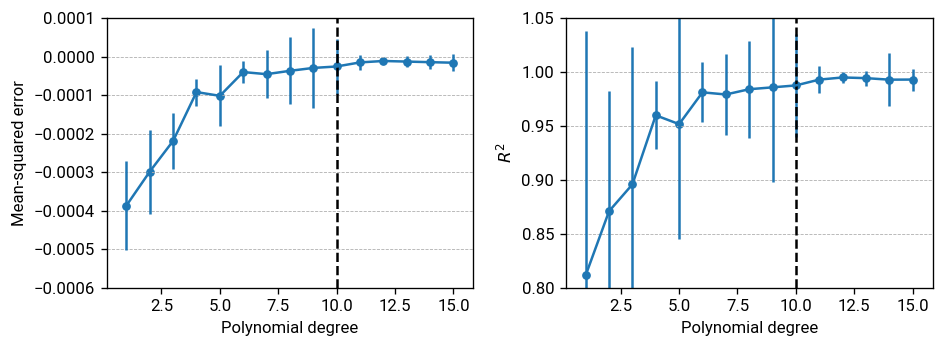

In [9]:
fig, ax = plt.subplots(ncols=2, dpi=120, figsize=(8, 3), sharex=True)
facets_info = [("mse", 0, r"Mean-squared error", (-0.0006, 0.0001)),
               ("r**2", 1, r"$R^{2}$", (0.80, 1.05))]

for facet in facets_info:
    facet_var, facet_id, facet_label, facet_ylim = facet
    sns.scatterplot(
        x="n",
        y=f"{facet_var}_mean",
        data=filip_poly_cv_scores_df,
        ax=ax[facet_id],
    )
    ax[facet_id].errorbar(
        filip_poly_cv_scores_df["n"],
        filip_poly_cv_scores_df[f"{facet_var}_mean"],
        yerr=filip_poly_cv_scores_df[f"{facet_var}_sd"],
    )
    ax[facet_id].axvline(x=10, linestyle="--", color="k")  # "True" polynomial degree
    ax[facet_id].set_ylim(facet_ylim)
    ax[facet_id].set_xlabel(r"Polynomial degree")
    ax[facet_id].set_ylabel(facet_label)

fig.tight_layout();

**Is there anything you notice about the error bars?**

We stored the trace for the MSE and $R^2$ cross-validation scores for all the polynomial summation fits. Let's extract those into their own data frame for further investigation. These are stored as lists *within* the data frame:

In [10]:
filip_poly_cv_scores_df.head()

,n,mse_trace,mse_mean,mse_sd,r**2_trace,r**2_mean,r**2_sd
0,1,"[-0.0002655000840979049, -0.000309608785706866...",-0.000387,0.000116,"[0.9353067868727876, 0.8848520918188416, 0.887...",0.811523,0.226243
1,2,"[-0.00035093502422535417, -0.00036404505354861...",-0.000299,0.000109,"[0.8408292357153826, 0.8818539134095313, 0.955...",0.870893,0.111087
2,3,"[-0.0003450857688101075, -0.000116658859101333...",-0.000219,0.000072,"[0.8944191578158613, 0.961863453035723, 0.8439...",0.895758,0.127610
3,4,"[-6.66109435229475e-05, -0.0001151911752646528...",-0.000092,0.000035,"[0.9683861428046507, 0.9618946871441366, 0.970...",0.959789,0.031457
4,5,"[-8.291874961374096e-05, -5.835601456815859e-0...",-0.000102,0.000079,"[0.959740135547202, 0.9828188896657719, 0.9857...",0.951594,0.106321


How can we extract these into a usable data frame without too much effort? We can extract an individual column as follows:

In [11]:
filip_poly_cv_scores_df["mse_trace"].head()

0    [-0.0002655000840979049, -0.000309608785706866...
1    [-0.00035093502422535417, -0.00036404505354861...
2    [-0.0003450857688101075, -0.000116658859101333...
3    [-6.66109435229475e-05, -0.0001151911752646528...
4    [-8.291874961374096e-05, -5.835601456815859e-0...
Name: mse_trace, dtype: object

We can use the `.tolist()` method to generate a list of these traces:

```python
filip_poly_cv_scores_df["mse_trace"].tolist()
```

If we pass this into `pd.DataFrame()`, then we get the following:

In [12]:
pd.DataFrame(filip_poly_cv_scores_df["mse_trace"].tolist())

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-0.000266,-0.000310,-0.000337,-0.000653,-0.000298,-0.000556,-0.000298,-0.000465,-0.000446,-0.000272,...,-0.000455,-0.000326,-0.000377,-0.000279,-0.000418,-0.000349,-0.000544,-0.000475,-0.000351,-0.000312
1,-0.000351,-0.000364,-0.000131,-0.000279,-0.000191,-0.000481,-0.000400,-0.000228,-0.000265,-0.000296,...,-0.000251,-0.000388,-0.000300,-0.000239,-0.000404,-0.000140,-0.000368,-0.000187,-0.000459,-0.000199
2,-0.000345,-0.000117,-0.000318,-0.000110,-0.000236,-0.000163,-0.000301,-0.000214,-0.000204,-0.000155,...,-0.000227,-0.000231,-0.000217,-0.000254,-0.000189,-0.000215,-0.000243,-0.000130,-0.000171,-0.000371
3,-0.000067,-0.000115,-0.000096,-0.000123,-0.000043,-0.000045,-0.000095,-0.000116,-0.000138,-0.000044,...,-0.000077,-0.000101,-0.000132,-0.000139,-0.000082,-0.000101,-0.000061,-0.000110,-0.000078,-0.000050
4,-0.000083,-0.000058,-0.000071,-0.000083,-0.000070,-0.000117,-0.000101,-0.000068,-0.000136,-0.000192,...,-0.000059,-0.000076,-0.000151,-0.000113,-0.000180,-0.000124,-0.000069,-0.000052,-0.000049,-0.000122
5,-0.000020,-0.000030,-0.000078,-0.000024,-0.000038,-0.000008,-0.000246,-0.000038,-0.000050,-0.000037,...,-0.000024,-0.000048,-0.000036,-0.000053,-0.000072,-0.000023,-0.000017,-0.000050,-0.000055,-0.000023
6,-0.000049,-0.000035,-0.000039,-0.000024,-0.000040,-0.000041,-0.000031,-0.000049,-0.000046,-0.000042,...,-0.000059,-0.000044,-0.000037,-0.000052,-0.000043,-0.000052,-0.000020,-0.000037,-0.000021,-0.000030
7,-0.000020,-0.000131,-0.000021,-0.000021,-0.000009,-0.000013,-0.000031,-0.000029,-0.000018,-0.000015,...,-0.000022,-0.000102,-0.000033,-0.000020,-0.000017,-0.000013,-0.000018,-0.000011,-0.000016,-0.000023
8,-0.000006,-0.000010,-0.000062,-0.000008,-0.000050,-0.000026,-0.000014,-0.000007,-0.000027,-0.000009,...,-0.000012,-0.000024,-0.000466,-0.000064,-0.000019,-0.000021,-0.000005,-0.000013,-0.000009,-0.000009
9,-0.000013,-0.000055,-0.000017,-0.000010,-0.000017,-0.000006,-0.000003,-0.000009,-0.000016,-0.000020,...,-0.000018,-0.000015,-0.000005,-0.000019,-0.000021,-0.000013,-0.000016,-0.000006,-0.000004,-0.000858


We can work with this! We just need to reshape the data. First, we need to restore the polynomial degree column `n`. We can use the `.assign()` method to achieve this:

In [13]:
pd.DataFrame(filip_poly_cv_scores_df["mse_trace"].tolist()) \
    .assign(n=range(1, 16))

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,n
0,-0.000266,-0.000310,-0.000337,-0.000653,-0.000298,-0.000556,-0.000298,-0.000465,-0.000446,-0.000272,...,-0.000326,-0.000377,-0.000279,-0.000418,-0.000349,-0.000544,-0.000475,-0.000351,-0.000312,1
1,-0.000351,-0.000364,-0.000131,-0.000279,-0.000191,-0.000481,-0.000400,-0.000228,-0.000265,-0.000296,...,-0.000388,-0.000300,-0.000239,-0.000404,-0.000140,-0.000368,-0.000187,-0.000459,-0.000199,2
2,-0.000345,-0.000117,-0.000318,-0.000110,-0.000236,-0.000163,-0.000301,-0.000214,-0.000204,-0.000155,...,-0.000231,-0.000217,-0.000254,-0.000189,-0.000215,-0.000243,-0.000130,-0.000171,-0.000371,3
3,-0.000067,-0.000115,-0.000096,-0.000123,-0.000043,-0.000045,-0.000095,-0.000116,-0.000138,-0.000044,...,-0.000101,-0.000132,-0.000139,-0.000082,-0.000101,-0.000061,-0.000110,-0.000078,-0.000050,4
4,-0.000083,-0.000058,-0.000071,-0.000083,-0.000070,-0.000117,-0.000101,-0.000068,-0.000136,-0.000192,...,-0.000076,-0.000151,-0.000113,-0.000180,-0.000124,-0.000069,-0.000052,-0.000049,-0.000122,5
5,-0.000020,-0.000030,-0.000078,-0.000024,-0.000038,-0.000008,-0.000246,-0.000038,-0.000050,-0.000037,...,-0.000048,-0.000036,-0.000053,-0.000072,-0.000023,-0.000017,-0.000050,-0.000055,-0.000023,6
6,-0.000049,-0.000035,-0.000039,-0.000024,-0.000040,-0.000041,-0.000031,-0.000049,-0.000046,-0.000042,...,-0.000044,-0.000037,-0.000052,-0.000043,-0.000052,-0.000020,-0.000037,-0.000021,-0.000030,7
7,-0.000020,-0.000131,-0.000021,-0.000021,-0.000009,-0.000013,-0.000031,-0.000029,-0.000018,-0.000015,...,-0.000102,-0.000033,-0.000020,-0.000017,-0.000013,-0.000018,-0.000011,-0.000016,-0.000023,8
8,-0.000006,-0.000010,-0.000062,-0.000008,-0.000050,-0.000026,-0.000014,-0.000007,-0.000027,-0.000009,...,-0.000024,-0.000466,-0.000064,-0.000019,-0.000021,-0.000005,-0.000013,-0.000009,-0.000009,9
9,-0.000013,-0.000055,-0.000017,-0.000010,-0.000017,-0.000006,-0.000003,-0.000009,-0.000016,-0.000020,...,-0.000015,-0.000005,-0.000019,-0.000021,-0.000013,-0.000016,-0.000006,-0.000004,-0.000858,10


We add a `score` label so that we know which cross-validation score we're dealing with:

In [14]:
pd.DataFrame(filip_poly_cv_scores_df["mse_trace"].tolist()) \
    .assign(n=range(1, 16), score="mse")

,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,n,score
0,-0.000266,-0.000310,-0.000337,-0.000653,-0.000298,-0.000556,-0.000298,-0.000465,-0.000446,-0.000272,...,-0.000377,-0.000279,-0.000418,-0.000349,-0.000544,-0.000475,-0.000351,-0.000312,1,mse
1,-0.000351,-0.000364,-0.000131,-0.000279,-0.000191,-0.000481,-0.000400,-0.000228,-0.000265,-0.000296,...,-0.000300,-0.000239,-0.000404,-0.000140,-0.000368,-0.000187,-0.000459,-0.000199,2,mse
2,-0.000345,-0.000117,-0.000318,-0.000110,-0.000236,-0.000163,-0.000301,-0.000214,-0.000204,-0.000155,...,-0.000217,-0.000254,-0.000189,-0.000215,-0.000243,-0.000130,-0.000171,-0.000371,3,mse
3,-0.000067,-0.000115,-0.000096,-0.000123,-0.000043,-0.000045,-0.000095,-0.000116,-0.000138,-0.000044,...,-0.000132,-0.000139,-0.000082,-0.000101,-0.000061,-0.000110,-0.000078,-0.000050,4,mse
4,-0.000083,-0.000058,-0.000071,-0.000083,-0.000070,-0.000117,-0.000101,-0.000068,-0.000136,-0.000192,...,-0.000151,-0.000113,-0.000180,-0.000124,-0.000069,-0.000052,-0.000049,-0.000122,5,mse
5,-0.000020,-0.000030,-0.000078,-0.000024,-0.000038,-0.000008,-0.000246,-0.000038,-0.000050,-0.000037,...,-0.000036,-0.000053,-0.000072,-0.000023,-0.000017,-0.000050,-0.000055,-0.000023,6,mse
6,-0.000049,-0.000035,-0.000039,-0.000024,-0.000040,-0.000041,-0.000031,-0.000049,-0.000046,-0.000042,...,-0.000037,-0.000052,-0.000043,-0.000052,-0.000020,-0.000037,-0.000021,-0.000030,7,mse
7,-0.000020,-0.000131,-0.000021,-0.000021,-0.000009,-0.000013,-0.000031,-0.000029,-0.000018,-0.000015,...,-0.000033,-0.000020,-0.000017,-0.000013,-0.000018,-0.000011,-0.000016,-0.000023,8,mse
8,-0.000006,-0.000010,-0.000062,-0.000008,-0.000050,-0.000026,-0.000014,-0.000007,-0.000027,-0.000009,...,-0.000466,-0.000064,-0.000019,-0.000021,-0.000005,-0.000013,-0.000009,-0.000009,9,mse
9,-0.000013,-0.000055,-0.000017,-0.000010,-0.000017,-0.000006,-0.000003,-0.000009,-0.000016,-0.000020,...,-0.000005,-0.000019,-0.000021,-0.000013,-0.000016,-0.000006,-0.000004,-0.000858,10,mse


We need to reshape the data frame so that the columns labeled 0 through 999 become rows. In the R `tidyverse` world, this is called `gather()`. In `pandas`, this is called `melt`:

In [15]:
pd.DataFrame(filip_poly_cv_scores_df["mse_trace"].tolist()) \
    .assign(n=range(1, 16), score="mse") \
    .melt(id_vars=["n", "score"], value_vars=list(range(1000)),
          var_name="cv_run", value_name="value") \
    .head(20)

,n,score,cv_run,value
0,1,mse,0,-0.000266
1,2,mse,0,-0.000351
2,3,mse,0,-0.000345
3,4,mse,0,-0.000067
4,5,mse,0,-0.000083
5,6,mse,0,-0.000020
6,7,mse,0,-0.000049
7,8,mse,0,-0.000020
8,9,mse,0,-0.000006
9,10,mse,0,-0.000013


We can use sorting so that we see all the cross-validation scores for a single polynomial model together in one chunk:

In [16]:
pd.DataFrame(filip_poly_cv_scores_df["mse_trace"].tolist()) \
    .assign(n=range(1, 16), score="mse") \
    .melt(id_vars=["n", "score"], value_vars=list(range(1000)),
          var_name="cv_run", value_name="value") \
    .sort_values(["score", "n", "cv_run"]) \
    .reset_index(drop=True) \
    .head(10)

,n,score,cv_run,value
0,1,mse,0,-0.000266
1,1,mse,1,-0.000310
2,1,mse,2,-0.000337
3,1,mse,3,-0.000653
4,1,mse,4,-0.000298
5,1,mse,5,-0.000556
6,1,mse,6,-0.000298
7,1,mse,7,-0.000465
8,1,mse,8,-0.000446
9,1,mse,9,-0.000272


Having pieced together the proper way to reshape this data, we repeat the same procedure for the `r**2_trace` column as well, then concatenate the two data frames together:

In [17]:
filip_cv_scores_dist_df = pd.concat(
    [
        pd.DataFrame(filip_poly_cv_scores_df["mse_trace"].tolist()) \
        .assign(n=[f"{x}" for x in range(1, 16)], score="mse") \
        .melt(id_vars=["n", "score"], value_vars=list(range(1000)),
              var_name="cv_run", value_name="value") \
        .sort_values(["score", "n", "cv_run"]) \
        .reset_index(drop=True),
        pd.DataFrame(filip_poly_cv_scores_df["r**2_trace"].tolist()) \
        .assign(n=[f"{x}" for x in range(1, 16)], score="r**2") \
        .melt(id_vars=["n", "score"], value_vars=list(range(1000)),
              var_name="cv_run", value_name="value") \
        .sort_values(["score", "n", "cv_run"]) \
        .reset_index(drop=True),
    ]
)

We now have a convenient data frame for accessing all of the cross-validation scores. We can look at the distribution of cross-validation scores to better understand what is going on. First, we look at the mean-squared error scores:

In [18]:
mse_scores_dist = filip_cv_scores_dist_df \
    .query("score == 'mse' & n != '1'") \
    .loc[:, ["n", "value"]] \
    .rename(columns={"n": "Degree"}) \
    .reset_index(drop=True)

Faceting over degrees 2 through 15, the distributions evolve as follows:

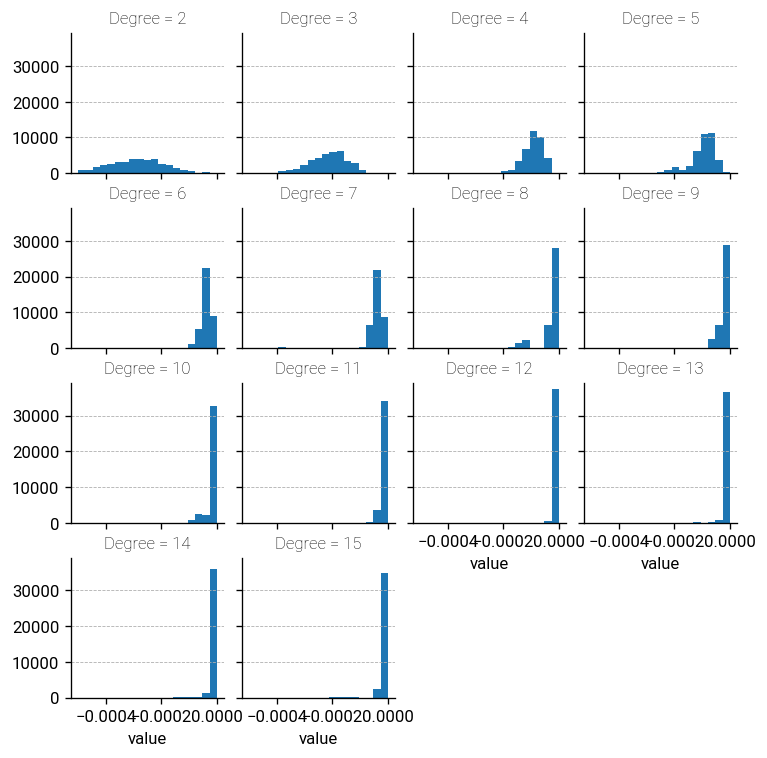

In [19]:
g = sns.FacetGrid(
    mse_scores_dist,
    col="Degree",
    col_wrap=4,
    col_order=[f"{n}" for n in range(2, 16)],
    sharex=True,
    sharey=True,
)

g = g.map(plt.hist, "value", density=True, bins=np.linspace(-0.0005, 0, 20))

g.fig.set_dpi(120)
g.fig.set_size_inches(6, 6);

We can make a similar series of plots for the $R^2$ score as well. First we query the data for those scores:

In [20]:
r2_scores_dist = filip_cv_scores_dist_df \
    .query("score == 'r**2' & n != '1'") \
    .loc[:, ["n", "value"]] \
    .rename(columns={"n": "Degree"}) \
    .reset_index(drop=True)

Faceting over degrees 2 through 15, the distributions evolve as follows:

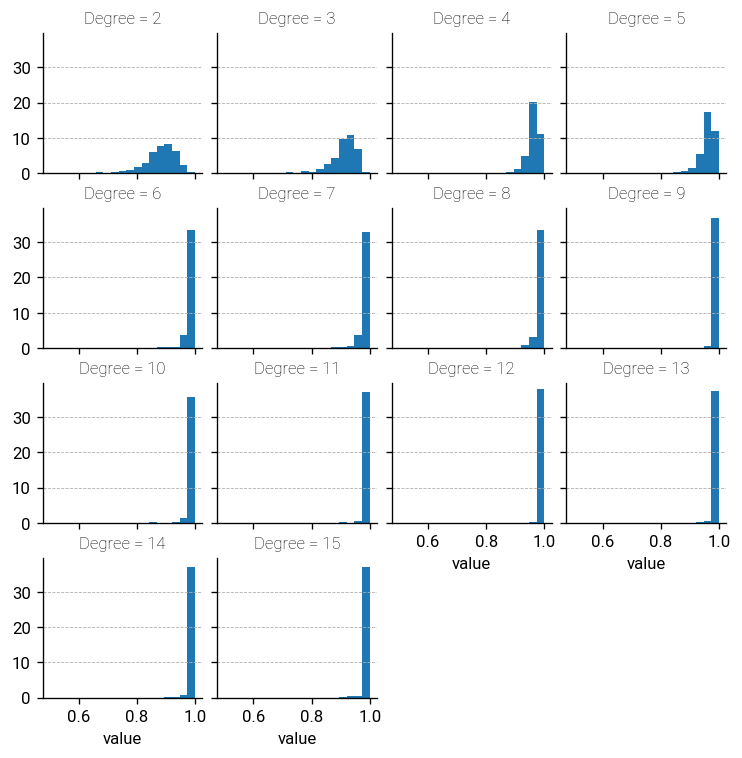

In [21]:
g = sns.FacetGrid(
    r2_scores_dist,
    col="Degree",
    col_wrap=4,
    col_order=[f"{n}" for n in range(2, 16)],
    sharex=True,
    sharey=True,
)

g = g.map(plt.hist, "value", density=True, bins=np.linspace(0.5, 1.0, 20))

g.fig.set_dpi(120)
g.fig.set_size_inches(6, 6);

We notice in both instances that the distributions are very skewed. They are not normally distributed, so it doesn't make sense to try and use the standard deviation we computed for our error bars. Instead, we can use **resampling**, also known as **bootstrapping**, to determine our error bars.

We use resampling to construct the bootstrap distribution of the mean score in the following way:

1.  For a given polynomial degree and score, randomly sample 1000 times with replacement from the `value` column.
2.  Compute the mean value and save the result.
3.  Repeat this many times, storing each mean value. We will repeat it 1000 times.
4.  Move on to the next polynomial degree, and repeat steps 1 through 3, storing the mean value each time.

The code to do this is given below:

In [22]:
bootstrap_results = {
    "n": [],
    "sample": [],
    "mean": [],
}

for n in range(2, 16):
    bootstrap_series = filip_cv_scores_dist_df \
        .query(f"score == 'mse' & n == '{n}'") \
        .sample(frac=1000, replace=True).loc[:, "value"]
    bootstrap_df = pd.DataFrame(bootstrap_series) \
        .assign(sample_id=[f"{x}" for x in range(1000) for _ in range(1000)])
    bootstrap_mean_samples = bootstrap_df \
        .groupby(["sample_id"]) \
        .mean() \
        .loc[:, "value"] \
        .values

    bootstrap_results["n"].extend(1000 * [f"{n}"])
    bootstrap_results["sample"].extend(list(range(1000)))
    bootstrap_results["mean"].extend(bootstrap_mean_samples)

filip_cv_scores_bootstrap_df = pd.DataFrame(bootstrap_results)

We now have a data frame containing our bootstrap distributions for the mean-squared error score for polynomial degrees 2 through 15:

In [23]:
filip_cv_scores_bootstrap_df.head()

,n,sample,mean
0,2,0,-0.000299
1,2,1,-0.000296
2,2,2,-0.000299
3,2,3,-0.000297
4,2,4,-0.000301


In [24]:
filip_cv_scores_bootstrap_df.tail()

,n,sample,mean
13995,15,995,-0.000016
13996,15,996,-0.000015
13997,15,997,-0.000016
13998,15,998,-0.000016
13999,15,999,-0.000015


Now we group over the `n` column, and within each group, determine the 2.5th and 97.5th percentiles. This gives us the upper and lower bounds of our 95% confidence intervals for our mean-squared error scores:

In [25]:
filip_mse_ci_95 = filip_cv_scores_bootstrap_df \
    .loc[:, ["n", "mean"]] \
    .groupby(["n"]) \
    .quantile([0.025, 0.975])
filip_mse_ci_95 = filip_mse_ci_95["mean"] \
    .unstack() \
    .reset_index() \
    .rename(columns={0.025: "lower", 0.975: "upper"})

Finally, we merge this back together with our original data frame of cross-validation scores:

In [26]:
filip_cv_final_df = filip_poly_cv_scores_df.copy().loc[:, ["n", "mse_mean"]].query("n > 1")
filip_cv_final_df["n"] = filip_cv_final_df["n"].astype(str)
filip_cv_final_df = filip_cv_final_df.merge(filip_mse_ci_95, on=["n"])

We compute the length of the y error bars from the mean, which is needed for `matplotlib`:

In [27]:
filip_cv_final_df["yerr_lower"] = np.abs(filip_cv_final_df["mse_mean"] - filip_cv_final_df["lower"])
filip_cv_final_df["yerr_upper"] = np.abs(filip_cv_final_df["mse_mean"] - filip_cv_final_df["upper"])

The data frame is now as follows:

In [28]:
filip_cv_final_df

,n,mse_mean,lower,upper,yerr_lower,yerr_upper
0,2,-0.000299,-0.000305,-0.000292,6.772445e-06,6.800843e-06
1,3,-0.000219,-0.000224,-0.000214,4.658103e-06,4.502134e-06
2,4,-0.000092,-0.000094,-0.000090,1.961853e-06,2.176045e-06
3,5,-0.000102,-0.000108,-0.000098,5.558076e-06,4.332210e-06
4,6,-0.000040,-0.000042,-0.000039,1.927361e-06,1.607447e-06
5,7,-0.000046,-0.000050,-0.000042,4.524589e-06,3.728316e-06
6,8,-0.000037,-0.000043,-0.000032,6.117658e-06,4.830110e-06
7,9,-0.000030,-0.000036,-0.000024,6.297591e-06,5.490149e-06
8,10,-0.000026,-0.000030,-0.000022,4.592369e-06,4.160836e-06
9,11,-0.000015,-0.000017,-0.000014,1.233232e-06,1.056722e-06


We visualize our mean-squared error scores, this time with proper error bars representing the 95% confidence interval for the mean scores:

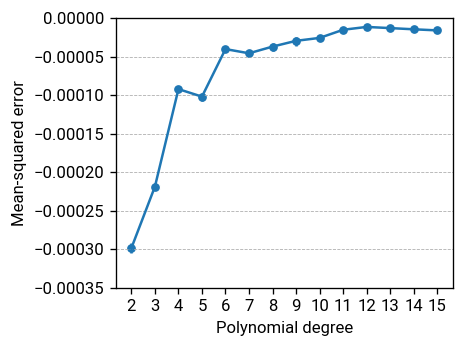

In [29]:
fig, ax = plt.subplots(dpi=120, figsize=(4, 3))
facet_var, facet_id, facet_label, facet_ylim = ("mse", 0, r"Mean-squared error", (-0.00035, 0.0))
sns.scatterplot(
    x="n",
    y=f"{facet_var}_mean",
    data=filip_cv_final_df,
    ax=ax,
)
ax.errorbar(
    filip_cv_final_df["n"],
    filip_cv_final_df[f"{facet_var}_mean"],
    yerr=[filip_cv_final_df["yerr_lower"], filip_cv_final_df["yerr_upper"]],
)
ax.set_ylim(facet_ylim)
ax.set_xlabel(r"Polynomial degree")
ax.set_ylabel(facet_label)

fig.tight_layout();

The error bars are very tiny, smaller than the size of the points.

To look at the spread of the cross-validation scores, we just need to compute the lower and upper bounds for the middle 95% of the values in the `filip_cv_scores_dist_df` data frame. The code below finds those percentiles and joins them into the data frame.

In [30]:
filip_cv_final_df2 = filip_cv_scores_dist_df \
    .query("score == 'mse'") \
    .loc[:, ["n", "value"]] \
    .groupby(["n"]) \
    .quantile([0.025, 0.975]) \
    .loc[:, "value"] \
    .unstack() \
    .reset_index() \
    .rename(columns={0.025: "dist_lower", 0.975: "dist_upper"}) \
    .merge(filip_cv_final_df, on="n") \
    .assign(yerr_dist_lower=lambda x: np.abs(x.dist_lower - x.mse_mean),
            yerr_dist_upper=lambda x: np.abs(x.dist_upper - x.mse_mean),
            n=lambda x: x.n.astype(int)) \
    .sort_values(["n"]) \
    .reset_index(drop=True) \
    .loc[:, ["n", "mse_mean", "lower", "upper", "yerr_lower", "yerr_upper",
             "dist_lower", "dist_upper", "yerr_dist_lower",
             "yerr_dist_upper"]]

Our data frame now looks as follows:

In [31]:
filip_cv_final_df2

,n,mse_mean,lower,upper,yerr_lower,yerr_upper,dist_lower,dist_upper,yerr_dist_lower,yerr_dist_upper
0,2,-0.000299,-0.000305,-0.000292,6.772445e-06,6.800843e-06,-0.000526,-0.000106,0.000227,0.000193
1,3,-0.000219,-0.000224,-0.000214,4.658103e-06,4.502134e-06,-0.000372,-0.000105,0.000153,0.000113
2,4,-0.000092,-0.000094,-0.000090,1.961853e-06,2.176045e-06,-0.000171,-0.000036,0.000079,0.000056
3,5,-0.000102,-0.000108,-0.000098,5.558076e-06,4.332210e-06,-0.000221,-0.000038,0.000119,0.000065
4,6,-0.000040,-0.000042,-0.000039,1.927361e-06,1.607447e-06,-0.000084,-0.000014,0.000044,0.000026
5,7,-0.000046,-0.000050,-0.000042,4.524589e-06,3.728316e-06,-0.000085,-0.000014,0.000039,0.000031
6,8,-0.000037,-0.000043,-0.000032,6.117658e-06,4.830110e-06,-0.000142,-0.000006,0.000105,0.000031
7,9,-0.000030,-0.000036,-0.000024,6.297591e-06,5.490149e-06,-0.000066,-0.000005,0.000036,0.000025
8,10,-0.000026,-0.000030,-0.000022,4.592369e-06,4.160836e-06,-0.000083,-0.000004,0.000058,0.000022
9,11,-0.000015,-0.000017,-0.000014,1.233232e-06,1.056722e-06,-0.000041,-0.000003,0.000026,0.000013


The visualization below shows the mean-squared error scores along with error bars that represent the spread of the cross-validation results (specifically, the middle 95%).

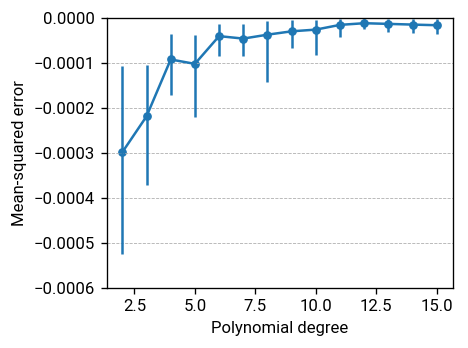

In [32]:
fig, ax = plt.subplots(dpi=120, figsize=(4, 3))
facet_var, facet_id, facet_label, facet_ylim = ("mse", 0, r"Mean-squared error", (-0.0006, 0.0))
sns.scatterplot(
    x="n",
    y=f"{facet_var}_mean",
    data=filip_cv_final_df2,
    ax=ax,
)
ax.errorbar(
    filip_cv_final_df2["n"],
    filip_cv_final_df2[f"{facet_var}_mean"],
    yerr=[filip_cv_final_df2["yerr_dist_lower"], filip_cv_final_df2["yerr_dist_upper"]],
)
ax.set_ylim(facet_ylim)
ax.set_xlabel(r"Polynomial degree")
ax.set_ylabel(facet_label)

fig.tight_layout();